<a href="https://www.kaggle.com/code/ibkya12/17-0-9243-house-price-pred-w-xgboost?scriptVersionId=180799341" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv') #Read Train Data
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv') #Read Test Data
subsample = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv') #Read Sample Submission Data 

In [3]:
train.head(3) # Let's see train data with head fu

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
test.head(3) # Let's see test data with head funciton

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


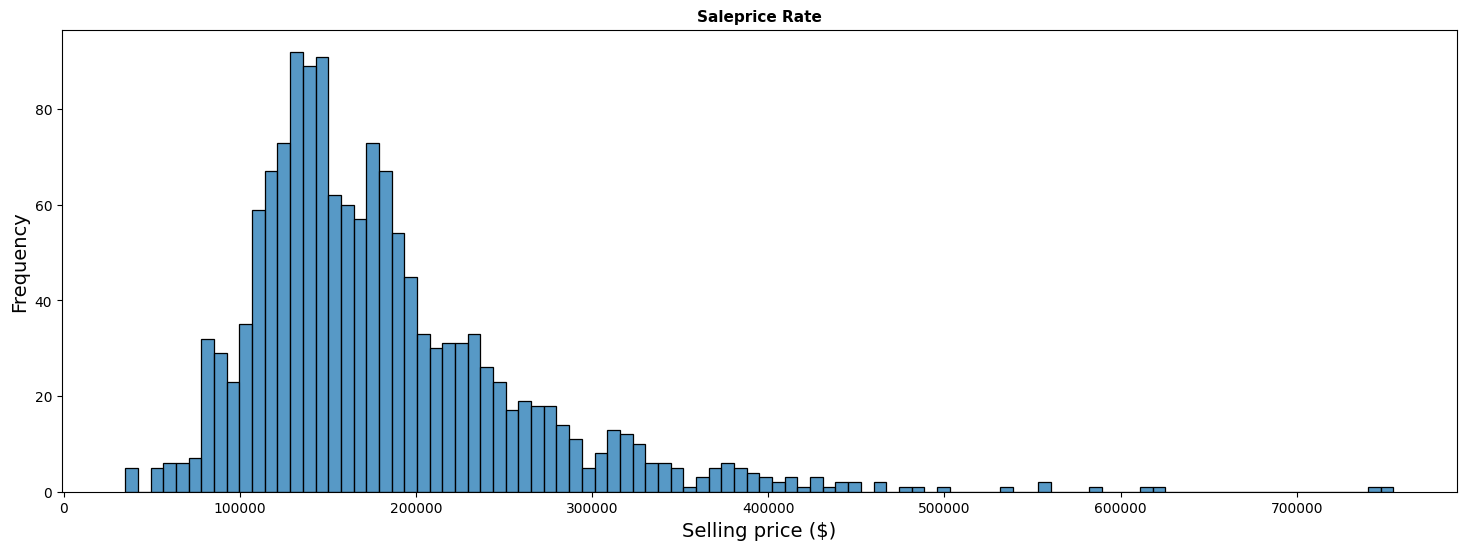

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [5]:
plt.figure(figsize=(18, 6))    # Create figure to analysis graphs.                                                                 

sns.histplot(train['SalePrice'], bins=100) # Creating Histogram Plot for see crosses in dataset.                                                     
plt.xlabel('Selling price ($)', fontsize=14)                                                   
plt.ylabel('Frequency', fontsize=14)                                                           
plt.title('Saleprice Rate', fontdict={'fontsize': 11, 'fontweight': 'bold'})                  

plt.show();                                                                                     

print(train['SalePrice'].describe())                                                           

In [6]:
#Eğitim veri seti için yeni özellikler oluşturma
#train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train['Total_Top_Bath'] = train['FullBath'] + (train['HalfBath'] * 0.5)
train['TotalPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
train['GarageAge'] = train['YrSold'] - train['GarageYrBlt']
train['TotalRooms'] = train['TotRmsAbvGrd'] + train['BedroomAbvGr']
train['HouseAge'] = train['YrSold'] - train['YearBuilt']
train['TotalSF'] = (train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF'] + train['GarageArea'] +
                 train['WoodDeckSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] +
                 train['3SsnPorch'] + train['ScreenPorch'])

train['TotalBath'] = train['FullBath'] + (train['HalfBath'] * 0.5) + train['BsmtFullBath'] + (train['BsmtHalfBath'] * 0.5)
train['Total_Bot_Bath'] = train['BsmtFullBath'] + (train['BsmtHalfBath'] * 0.5)

train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)


#Test veri seti için yeni özellikler oluşturma

test['Total_Top_Bath'] = test['FullBath'] + (test['HalfBath'] * 0.5)
test['Total_Bot_Bath'] = test['BsmtFullBath'] + (test['BsmtHalfBath'] * 0.5)

test['HasGarage'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
test['TotalSF'] = (test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF'] + test['GarageArea'] +
                 test['WoodDeckSF'] + test['OpenPorchSF'] + test['EnclosedPorch'] +
                 test['3SsnPorch'] + test['ScreenPorch'])

test['HouseAge'] = test['YrSold'] - test['YearBuilt']
test['GarageAge'] = test['YrSold'] - test['GarageYrBlt']
test['TotalRooms'] = test['TotRmsAbvGrd'] + test['BedroomAbvGr']
#test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
test['TotalBath'] = test['BsmtFullBath'] + (test['BsmtHalfBath'] * 0.5) + test['FullBath'] + (test['HalfBath'] * 0.5)
test['TotalPorchSF'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

In [7]:
# Additional feature engineering for the training set

# Remodel Age
train['RemodelAge'] = train['YrSold'] - train['YearRemodAdd']

# Is New
train['IsNew'] = train.apply(lambda x: 1 if x['YearBuilt'] == x['YrSold'] else 0, axis=1)

# Overall Quality-Condition
train['OverallQualCond'] = train['OverallQual'] * train['OverallCond']

# Total Area (TotalSF already includes most areas)
train['TotalArea'] = train['TotalSF'] + train['LotArea']

# Bathrooms per Room
train['BathsPerRoom'] = train['TotalBath'] / train['TotRmsAbvGrd']

# Porch to Lot Area Ratio
train['PorchLotAreaRatio'] = train['TotalPorchSF'] / train['LotArea']

# Repeat for the test set

test['RemodelAge'] = test['YrSold'] - test['YearRemodAdd']
test['IsNew'] = test.apply(lambda x: 1 if x['YearBuilt'] == x['YrSold'] else 0, axis=1)
test['OverallQualCond'] = test['OverallQual'] * test['OverallCond']
test['TotalArea'] = test['TotalSF'] + test['LotArea']
test['BathsPerRoom'] = test['TotalBath'] / test['TotRmsAbvGrd']
test['PorchLotAreaRatio'] = test['TotalPorchSF'] / test['LotArea']

## Grouping NaN values with setted algorithm.

In [8]:
columns_to_impute_train = []
columns_to_remove_train = []

columns_to_impute_test = []
columns_to_remove_test = []

for column in train.columns:                                                       
    null_count = train[column].isnull().sum()                                      
    if null_count >= 500:                                                          
        columns_to_remove_train.append(column)
    elif null_count >= 1:                                                          
        columns_to_impute_train.append(column)
    else:                                                                          
        pass

for column in test.columns:                                                        
    null_count = test[column].isnull().sum()
    if null_count >= 500:
        columns_to_remove_test.append(column)
    elif null_count >= 1:
        columns_to_impute_test.append(column)
    else:
        pass

print("Columns to impute in train ", columns_to_impute_train, '\n')
print("Columns to remove in train: ", columns_to_remove_train, '\n')

print("Columns to impute in test: ", columns_to_impute_test, '\n')
print("Columns to remove in test: ", columns_to_remove_test)

Columns to impute in train  ['LotFrontage', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageAge'] 

Columns to remove in train:  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] 

Columns to impute in test:  ['MSZoning', 'LotFrontage', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'SaleType', 'Total_Bot_Bath', 'TotalSF', 'GarageAge', 'TotalBath', 'TotalArea', 'BathsPerRoom'] 

Columns to remove in test:  ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [9]:
train_clean = train.drop(['Id','PoolQC','PoolArea','Fence', 'MiscFeature'], axis = 1)                                 
test_clean = test.drop(['PoolQC','PoolArea','Fence', 'MiscFeature'], axis = 1)

In [10]:
cat_columns_train = train_clean.select_dtypes(include=['object'])                          
cat_columns_test = test_clean.select_dtypes(include=['object'])                            

print(cat_columns_train.columns)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


In [11]:
label_encoder = LabelEncoder()                                                             

for columna in cat_columns_train.columns:                                                  
    train_clean[columna] = label_encoder.fit_transform(train_clean[columna])               

for columna in cat_columns_test.columns:
    test_clean[columna] = label_encoder.fit_transform(test_clean[columna])
    
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 91 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int64  
 1   MSZoning           1460 non-null   int64  
 2   LotFrontage        1201 non-null   float64
 3   LotArea            1460 non-null   int64  
 4   Street             1460 non-null   int64  
 5   Alley              1460 non-null   int64  
 6   LotShape           1460 non-null   int64  
 7   LandContour        1460 non-null   int64  
 8   Utilities          1460 non-null   int64  
 9   LotConfig          1460 non-null   int64  
 10  LandSlope          1460 non-null   int64  
 11  Neighborhood       1460 non-null   int64  
 12  Condition1         1460 non-null   int64  
 13  Condition2         1460 non-null   int64  
 14  BldgType           1460 non-null   int64  
 15  HouseStyle         1460 non-null   int64  
 16  OverallQual        1460 

In [12]:
knn_imputer_train = KNNImputer(n_neighbors=5, metric='nan_euclidean')                                           
knn_imputer_train.fit(train_clean[columns_to_impute_train])                                                     

train_clean[columns_to_impute_train] = knn_imputer_train.transform(train_clean[columns_to_impute_train])        


knn_imputer_test = KNNImputer(n_neighbors=5, metric='nan_euclidean')
knn_imputer_test.fit(test_clean[columns_to_impute_test])

test_clean[columns_to_impute_test] = knn_imputer_test.transform(test_clean[columns_to_impute_test])


print("No. of nulls in the dataset: ", train_clean.isnull().sum().sum())

No. of nulls in the dataset:  0


In [13]:
correlations = train_clean.corr()

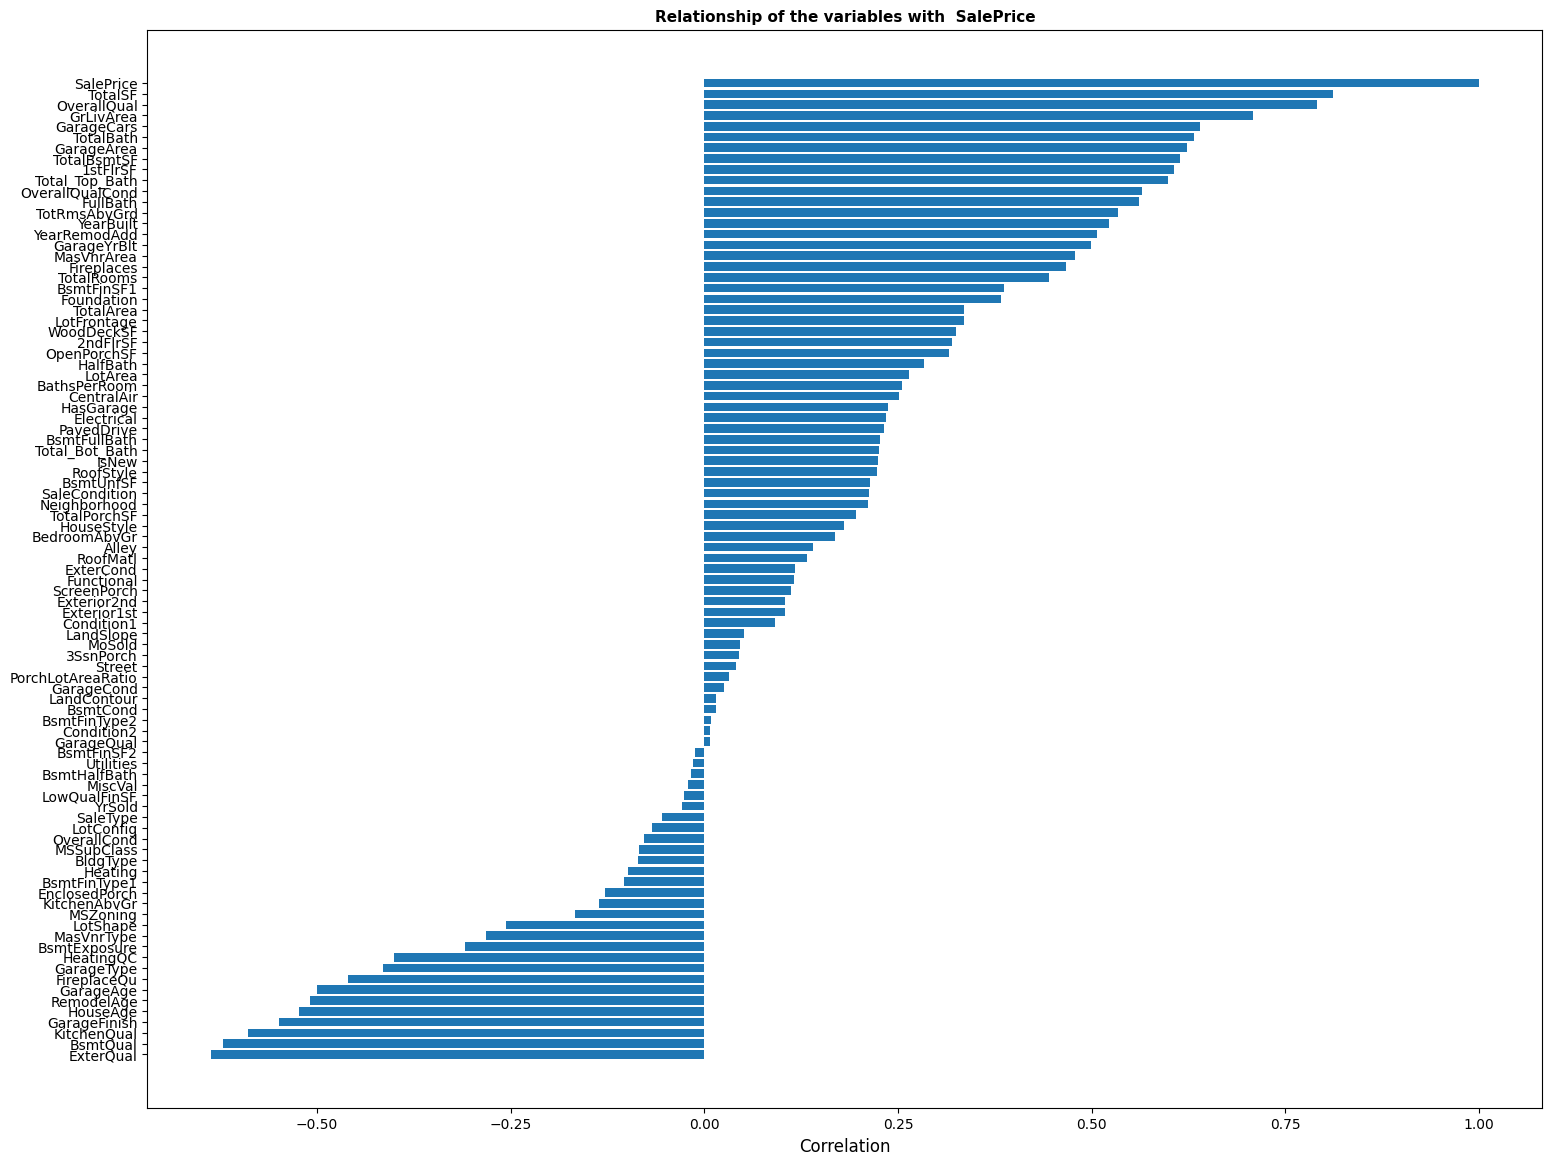

In [14]:
corr = train_clean.corr()                                               
corr_sale = corr['SalePrice'].sort_values(ascending=False)              

plt.figure(figsize=(18, 14))                                            

plt.barh(corr_sale.index, corr_sale.values)                             
plt.xlabel("Correlation", size=12)
plt.ylabel("")
plt.title("Relationship of the variables with  SalePrice", fontdict={'fontsize': 11, 'fontweight': 'bold'})
plt.gca().invert_yaxis()                                                

plt.show()

In [15]:
corr_matrix = train_clean.corr()

saleprice_corr = corr_matrix['SalePrice']

threshold = 0.50
high_corr_vars = saleprice_corr[abs(saleprice_corr) > threshold]


for var, corr_value in zip(high_corr_vars.index, high_corr_vars.values):
    print(f"{var} and SalePrice Correlation value: {corr_value:.2f}") 

OverallQual and SalePrice Correlation value: 0.79
YearBuilt and SalePrice Correlation value: 0.52
YearRemodAdd and SalePrice Correlation value: 0.51
ExterQual and SalePrice Correlation value: -0.64
BsmtQual and SalePrice Correlation value: -0.62
TotalBsmtSF and SalePrice Correlation value: 0.61
1stFlrSF and SalePrice Correlation value: 0.61
GrLivArea and SalePrice Correlation value: 0.71
FullBath and SalePrice Correlation value: 0.56
KitchenQual and SalePrice Correlation value: -0.59
TotRmsAbvGrd and SalePrice Correlation value: 0.53
GarageFinish and SalePrice Correlation value: -0.55
GarageCars and SalePrice Correlation value: 0.64
GarageArea and SalePrice Correlation value: 0.62
SalePrice and SalePrice Correlation value: 1.00
Total_Top_Bath and SalePrice Correlation value: 0.60
GarageAge and SalePrice Correlation value: -0.50
HouseAge and SalePrice Correlation value: -0.52
TotalSF and SalePrice Correlation value: 0.81
TotalBath and SalePrice Correlation value: 0.63
RemodelAge and Sal

In [16]:
street_count = train['Street'].value_counts()
print(street_count)

Street
Pave    1454
Grvl       6
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


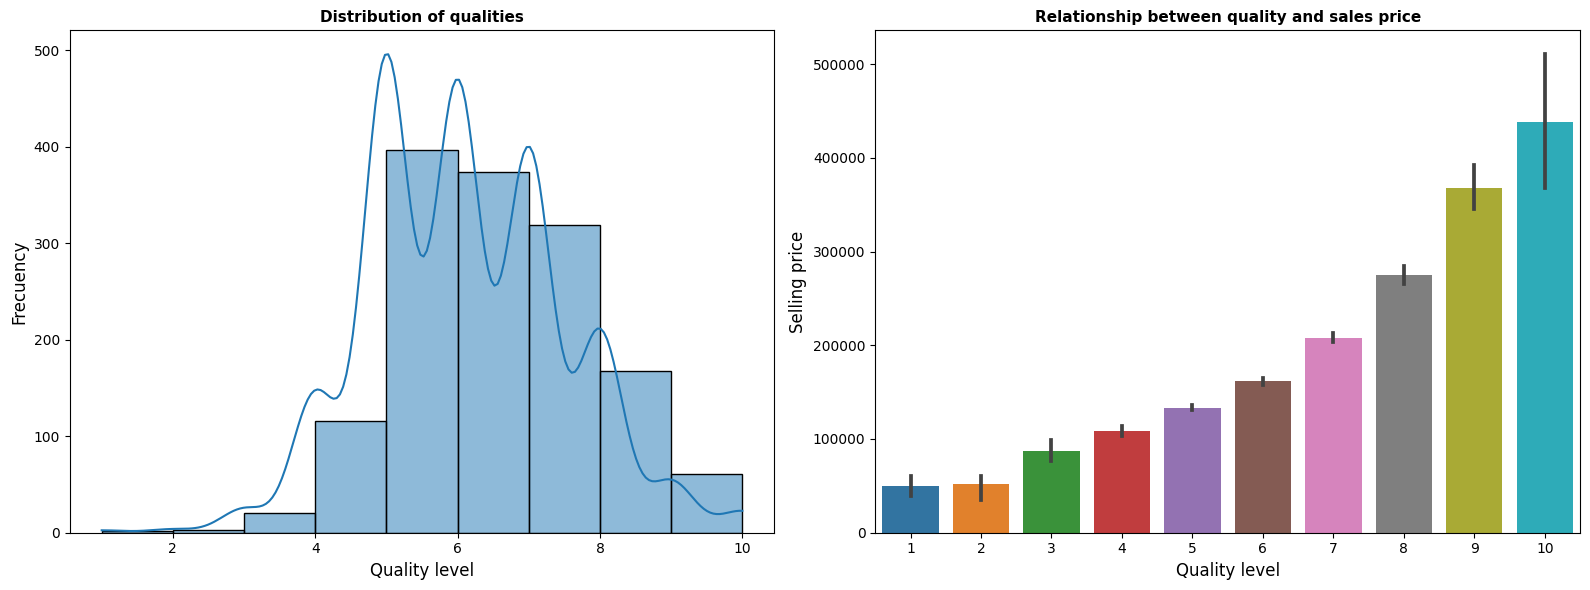

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))                                                                  

sns.histplot(data=train_clean, x='OverallQual', ax=axes[0], bins=range(1, 11), kde=True)                         
axes[0].set_xlabel('Quality level', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('Distribution of qualities', size=11, weight='bold')

sns.barplot(data=train_clean, x='OverallQual', y='SalePrice', ax=axes[1])                                        
axes[1].set_xlabel('Quality level', size=12) 
axes[1].set_ylabel('Selling price', size=12)
axes[1].set_title('Relationship between quality and sales price', size=11, weight='bold')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


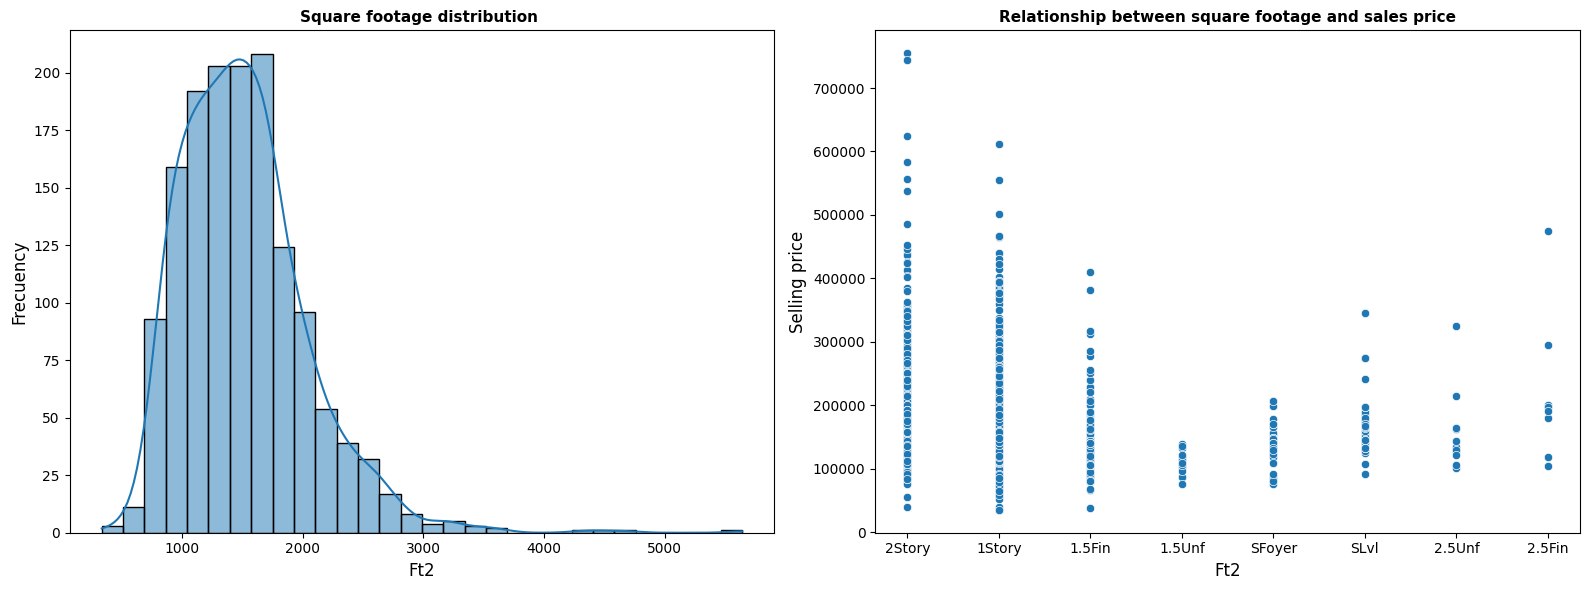

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean, x='GrLivArea', ax=axes[0], bins=30, kde=True)                                       
axes[0].set_xlabel('Ft2', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('Square footage distribution ', size=11, weight='bold')
 
sns.scatterplot(data=train, x='HouseStyle', y='SalePrice', ax=axes[1])                                           
axes[1].set_xlabel('Ft2', size=12)
axes[1].set_ylabel('Selling price', size=12)
axes[1].set_title('Relationship between square footage and sales price', size=11, weight='bold')

plt.tight_layout()
plt.show()

## GarageCars with Ft^2 Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


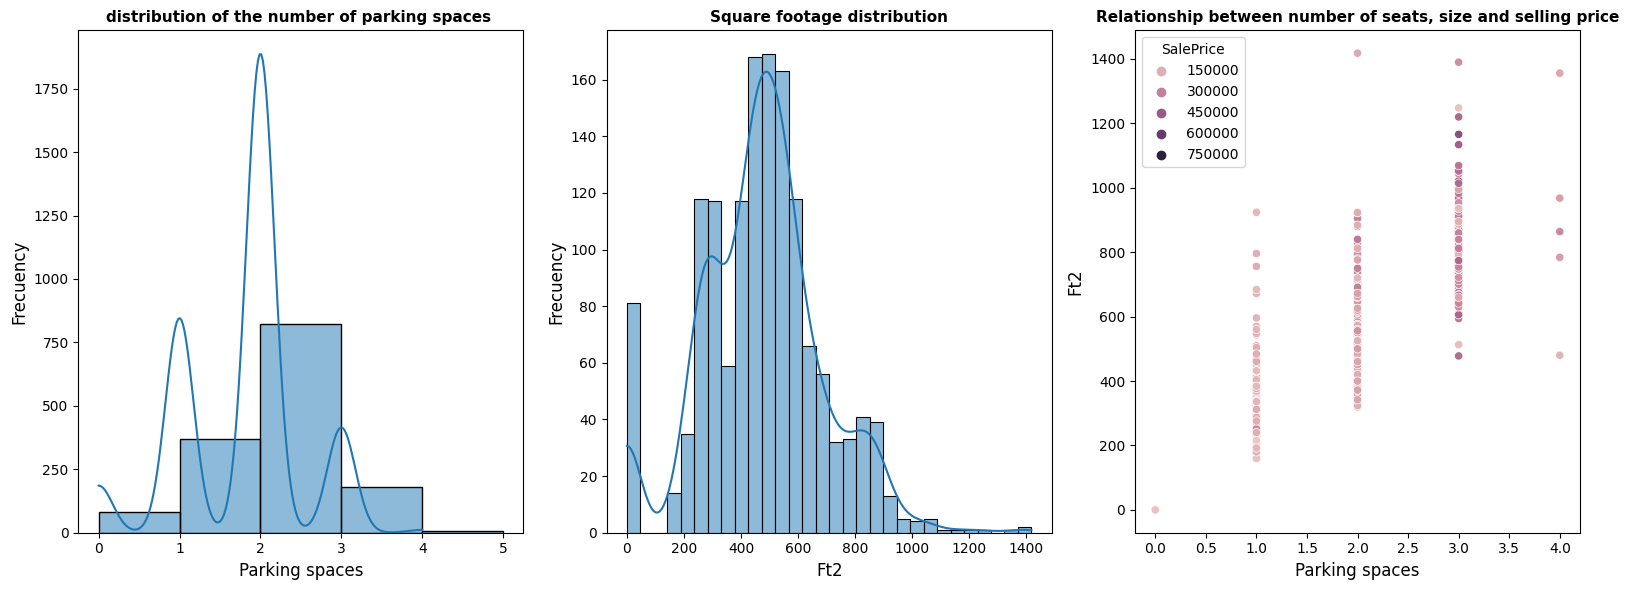

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))                                                                   

sns.histplot(data=train_clean, x='GarageCars', ax=axes[0], bins=range(6), kde=True)                               
axes[0].set_xlabel('Parking spaces', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('distribution of the number of parking spaces ', size=11, weight='bold')

sns.histplot(data=train_clean, x='GarageArea', ax=axes[1], bins=30, kde=True)                                     
axes[1].set_xlabel('Ft2', size=12)
axes[1].set_ylabel('Frecuency', size=12)
axes[1].set_title('Square footage distribution', size=11, weight='bold')

sns.scatterplot(data=train_clean, x='GarageCars', y='GarageArea', hue='SalePrice', ax=axes[2])                    
axes[2].set_xlabel('Parking spaces', size=12)
axes[2].set_ylabel('Ft2', size=12)
axes[2].set_title('Relationship between number of seats, size and selling price', size=11, weight='bold')

plt.tight_layout()
plt.show()

## TotalBstmSF with FT^2 Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


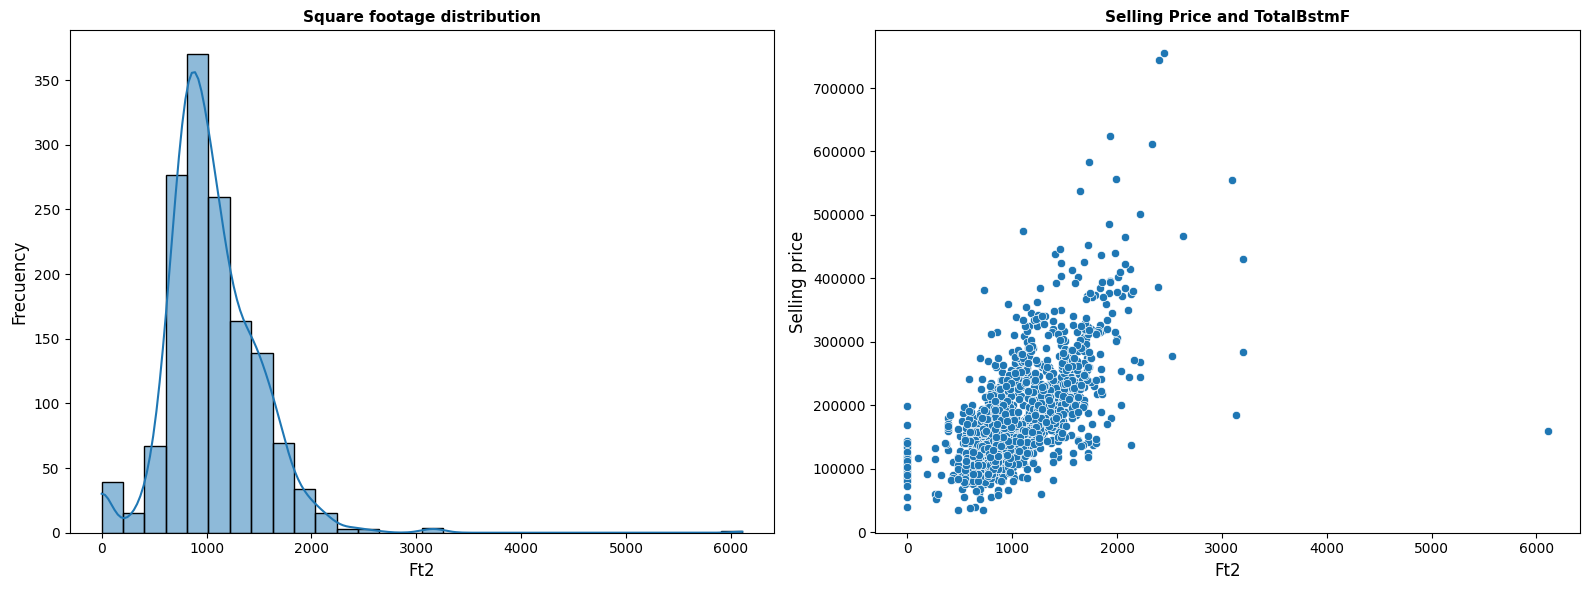

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(data=train_clean, x='TotalBsmtSF', ax=axes[0], bins=30, kde=True)                                    
axes[0].set_xlabel('Ft2', size=12)
axes[0].set_ylabel('Frecuency', size=12)
axes[0].set_title('Square footage distribution', size=11, weight='bold')

sns.scatterplot(data=train_clean, x='TotalBsmtSF', y='SalePrice', ax=axes[1])                                     
axes[1].set_xlabel('Ft2', size=12)
axes[1].set_ylabel('Selling price', size=12)
axes[1].set_title('Selling Price and TotalBstmF', size=11, weight='bold')

plt.tight_layout()
plt.show()

## Linear Regression Model Predict

In [21]:
X_train = train_clean[['OverallQual']]
y_train = train_clean['SalePrice']
X_test = test_clean[['OverallQual']]

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

simple_predictions = lr_model.predict(X_test)

rmse_simple = np.sqrt(mean_squared_error(y_train, lr_model.predict(X_train)))
r2_simple = r2_score(y_train, lr_model.predict(X_train))

## Simple Linear Regression Predict Visualization

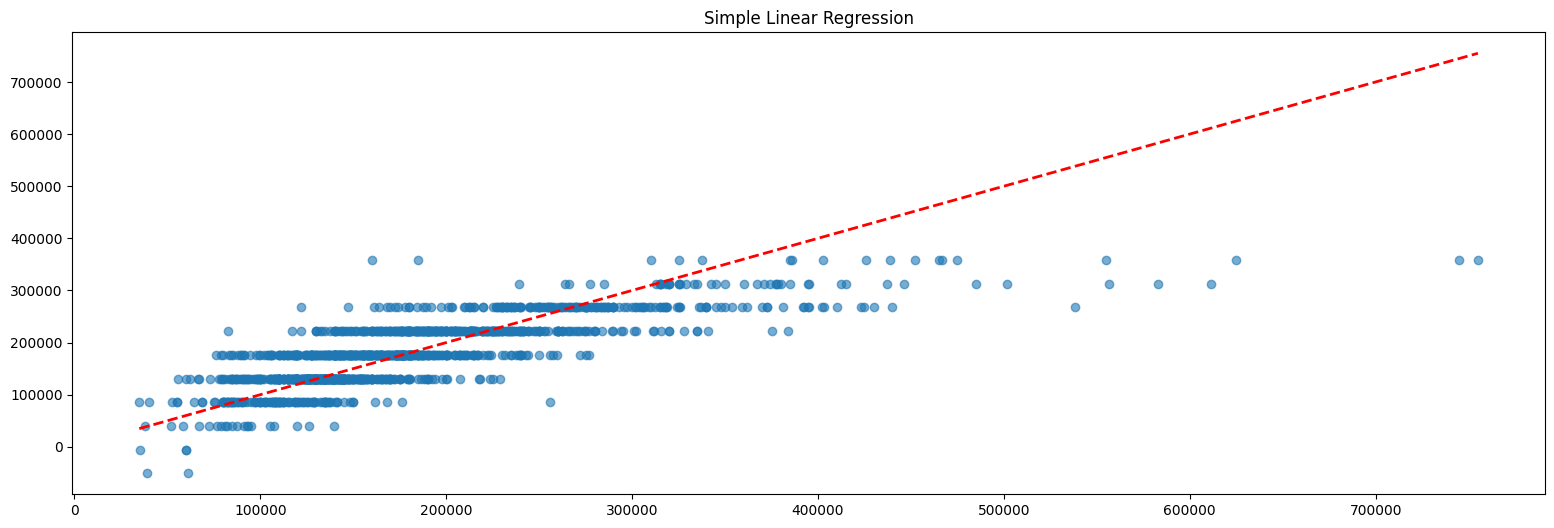

Simple Linear Regression RMSE: 48589.44712143806
Simple Linear Regression  R-squared: 0.625651892462118


In [22]:
plt.figure(figsize=(19, 6))
plt.scatter(y_train, lr_model.predict(X_train), alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Simple Linear Regression')
plt.show()


print(f"Simple Linear Regression RMSE: {rmse_simple}")
print(f"Simple Linear Regression  R-squared: {r2_simple}")

## Multiple Linear Regression Model Predict

In [23]:
X = train_clean.drop(columns=['SalePrice'])
y = train_clean['SalePrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)                                 

y_pred = model.predict(X_test)

test_clean_aligned = test_clean[X.columns]
test_clean_scaled = scaler.transform(test_clean_aligned)
test_predictions = model.predict(test_clean_scaled)

rmse_multiple = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred)))
r2_multiple = r2_score(y_test, y_pred)

## Multiple Linear Regression Predict Visuaization

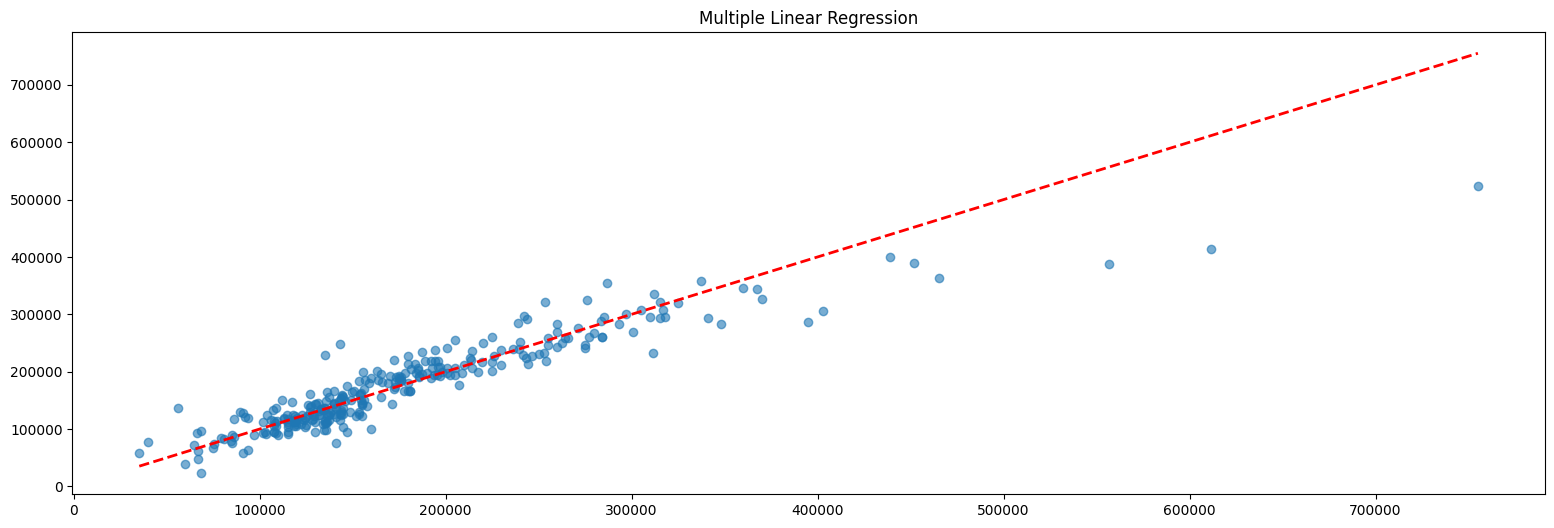

Multiple Linear Regression RMSE: 0.18300702573156624
Multiple Linear Regression R-squared: 0.8545821058173267


In [24]:
plt.figure(figsize=(19, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('')
plt.ylabel('')
plt.title('Multiple Linear Regression')
plt.show()

print(f"Multiple Linear Regression RMSE: {rmse_multiple}")
print(f"Multiple Linear Regression R-squared: {r2_multiple}")

## Ridge Regressor Predict

In [25]:
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10,100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_

y_pred_ridge = best_ridge.predict(X_test)
test_predictions_ridge = best_ridge.predict(test_clean_scaled)

rmse_ridge = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_ridge)))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {rmse_ridge}")
print(f"Ridge Regression R-squared: {r2_ridge}")

Ridge Regression RMSE: 0.1717960873618798
Ridge Regression R-squared: 0.8547232778660909


## Lasso Regressor Predict

In [26]:
lasso = Lasso(max_iter=20000)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_

y_pred_lasso = best_lasso.predict(X_test)
test_predictions_lasso = best_lasso.predict(test_clean_scaled)

rmse_lasso = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_lasso)))
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Regression RMSE: {rmse_lasso}")
print(f"Lasso Regression R-squarede: {r2_lasso}") 

Lasso Regression RMSE: 0.1793351844312162
Lasso Regression R-squarede: 0.8541254027777223


## k-NN Regressor Predict

In [27]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

knn_rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_knn)))
knn_r2 = r2_score(y_test, y_pred_knn)

print(f"KNN Regression RMSE: {knn_rmse}")
print(f"KNN Regression R-squared: {knn_r2}")

KNN Regression RMSE: 0.1875394194529121
KNN Regression R-squared: 0.8131028877999347


## ElasitcNet Regressor Model Predict

In [28]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)


y_pred_en = elastic_net.predict(X_test)


en_rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_en)))
en_r2 = r2_score(y_test, y_pred_en)

print(f"ElasticNet RMSE: {en_rmse}")
print(f"ElasticNet R-squared: {en_r2}")

ElasticNet RMSE: 0.1750900195848705
ElasticNet R-squared: 0.8550993660739358


## Gradient Boosting Regressor Model Predict

In [29]:
gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)


y_pred_gb = gb.predict(X_test)


gb_rmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_gb)))
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting RMSE: {gb_rmse}")
print(f"Gradient Boosting R-squared: {gb_r2}")

Gradient Boosting RMSE: 0.14115179397088098
Gradient Boosting R-squared: 0.9077994720169297


## Category Boosting Regressor Model Predict [BEST SCORE]

In [30]:
catb = CatBoostRegressor()
catb_model = catb.fit(X_train, y_train,
                     verbose = 0)

y_pred_catb = catb_model.predict(X_test)

catb_rmse_calculator = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_catb)))
catboost_r2_metric = r2_score(y_test, y_pred_catb)

print(f"Category Boosting RMSE Metric: {catb_rmse_calculator}")
print(f"Category Boosting R-squared Metric: {catboost_r2_metric}")

Category Boosting RMSE Metric: 0.13463217223791496
Category Boosting R-squared Metric: 0.91329333709306


## Last Analysis: Let's Testing XGBoost

In [31]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     #objective='reg:linear', nthread=-1,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgb_model = xgb.fit(X_train , y_train)

y_pred_xgboost = xgb_model.predict(X_test)

xgboost_rmse_calculator = np.sqrt(mean_squared_error(np.log(y_test), np.log(y_pred_xgboost)))
xgboost_r2_metric = r2_score(y_test, y_pred_xgboost)

print(f"Extreme Gradient Boosting RMSE Metric: {xgboost_rmse_calculator}")
print(f"Extreme Gradient Boosting R-squared Metric: {xgboost_r2_metric}")

Extreme Gradient Boosting RMSE Metric: 0.12981379813900926
Extreme Gradient Boosting R-squared Metric: 0.922268266237555


In [32]:
test_pred_xgboost = xgb_model.predict(test_clean_scaled)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test_pred_xgboost
})

print(submission.head())
submission.to_csv('/kaggle/working/submission_xg.csv', index=False)

     Id      SalePrice
0  1461  133359.343750
1  1462  161746.140625
2  1463  187567.593750
3  1464  191641.296875
4  1465  187125.296875


In [33]:
test_pred_xgb = xgb_model.predict(test_clean_scaled)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test_pred_xgb
})

print(submission.head())
submission.to_csv('/kaggle/working/submission.csv', index=False)

     Id      SalePrice
0  1461  133359.343750
1  1462  161746.140625
2  1463  187567.593750
3  1464  191641.296875
4  1465  187125.296875
